# **Similarity Based Bi-Directional LSTM Model for Clickbait Detection**






**SUBMITTED BY :**

              1. NAMAN JUNEJA (2020201072)
              2. SOMYA LALWANI (2020201092)
              3. PULLAMMA MAYAKUNTALA (2018101119)

## IMPORTING LIBRARIES

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder  #for label encoding
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from numpy.linalg import norm


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

!pip install tensorflow
!pip install --upgrade tensorflow
from tensorflow.keras.layers import LSTM, MaxPool1D, Dropout, Dense, GlobalMaxPooling1D, Embedding, Activation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import tensorflow as tf
#import tensorflow.compat.v1 as tf


from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from google.colab import files

from numpy import dot
from numpy.linalg import norm
from keras.backend import int_shape
from keras.layers import LSTM
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)




## OPENING TRAIN.CSV & VALID.CSV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def open_filter_data(filename):
    
    data = pd.read_csv("drive/MyDrive/SMAI_PROJECT_CLICKBAIT/"+filename+".csv", na_values='?', header=None,) 
    #data = pd.read_csv("clickbait-news-detection/"+filename+".csv", na_values='?', header=None,) 
    data.head()
    df=data.dropna(axis = 0, how ='any')
    #print(df.shape)
    df=df.reset_index(drop=True)
    return df
    

df_train=open_filter_data("train")
df_valid=open_filter_data("valid")
df_test=open_filter_data("test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training data description

In [ ]:
df_train.describe

<bound method NDFrame.describe of            0  ...          3
0         id  ...      label
1          0  ...       news
2          1  ...       news
3          2  ...  clickbait
4          3  ...  clickbait
...      ...  ...        ...
19873  24864  ...      other
19874  24867  ...       news
19875  24868  ...       news
19876  24869  ...       news
19877  24870  ...       news

[19878 rows x 4 columns]>

## Validation data description

In [ ]:
df_valid.describe

<bound method NDFrame.describe of          0  ...      3
0       id  ...  label
1        0  ...   news
2        1  ...   news
3        2  ...   news
4        3  ...   news
...    ...  ...    ...
2820  3544  ...   news
2821  3545  ...   news
2822  3547  ...   news
2823  3550  ...   news
2824  3551  ...   news

[2825 rows x 4 columns]>

## Testing data description

In [ ]:
df_test.describe

<bound method NDFrame.describe of          0  ...                                                  2
0       id  ...                                               text
1        0  ...  More Try Yahoo Finance on Firefox » Amazon CEO...
2        1  ...  More Laura Dern seems to be everywhere these d...
3        2  ...  Kirkuk is a city of Northern Iraq in the Kurdi...
4        3  ...  Experts say that communication is the cornerst...
...    ...  ...                                                ...
5625  5642  ...  “Watch out boy, she’ll chew you up.” On this d...
5626  5643  ...  Fire broke out at an upmarket apartment block ...
5627  5644  ...  For the first time, a database has compiled a ...
5628  5645  ...  Vin Diesel has sometimes been known to jump th...
5629  5646  ...  In three days, Donald Trump is all set to assu...

[5630 rows x 3 columns]>

## EXTRACTING COLUMNS FROM TRAINING DATA & VALIDATION DATA

In [ ]:
def extract_data(df):
    a=df.iloc[1:,2]
    b=df.iloc[1:,1]
    df.iloc[:,3] = df.iloc[:,3].str.replace('news','1')
    df.iloc[:,3] = df.iloc[:,3].str.replace('clickbait','0')
    y_actual=df.iloc[1:,3]
    return a,b,y_actual

def extract_dd(df):
    a=df.iloc[1:,2]
    b=df.iloc[1:,1]
    return a,b
    

a_train,b_train,y_actual=extract_data(df_train)
a_valid,b_valid,y_valid=extract_data(df_valid)
a_test,b_test=extract_dd(df_test)


In [ ]:
print("TRAINING DATA ---->")
print()
print("Heading---->")
print()
print(a_train[:5])
print()
print("Body--->")
print()
print(b_train[:5])
print()
print("Y---->")
print("1 means News & 0 means Clickbait")
print()
print(y_actual[:5])

print()
print("Similar for validation & testing data")

TRAINING DATA ---->

Heading---->

1    Economists generally agree: China must overhau...
2    LONDON—British Prime Minister Theresa May said...
3    Beaches come in all sorts of shapes and sizes ...
4    A timeline of what happened after Tamir Rice, ...
5    An Italian neurosurgeon who has claimed for mo...
Name: 2, dtype: object

Body--->

1    China and Economic Reform: Xi Jinping’s Track ...
2    Trade to Be a Big Topic in Theresa May’s U.S. ...
3    The Top Beaches In The World, According To Nat...
4    Sheriff’s Report Provides New Details on Tamir...
5    Surgeon claiming he will transplant volunteer'...
Name: 1, dtype: object

Y---->
1 means News & 0 means Clickbait

1    1
2    1
3    0
4    0
5    1
Name: 3, dtype: object

Similar for validation & testing data


## Preprocess All Data (Training, Validation, Testing)


1. Converting all sentences to lower case 
2. Writing Abbreviations in full form
3. Removing punctuations (Normalisation)
4. Removing Stop words (Normalisation)
5. Lemmatizing the data


In [ ]:
contractions = {
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
"'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
"didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
"hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
"he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
"i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have",
"i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
"let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
"mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
"oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
"shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
"shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that had",
"that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
"there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
"we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
"what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
"what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
"where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why has", "why've": "why have",
"will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
"wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
"y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
"you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}


def pre_process_data(a,b):
    final_lines=[]
    final_headings=[]


    for line in range(1,int(0.25*len(a))):
      #print(a[line])
      #print(type(a[line]))
      #print("*********")
      a[line]=(a[line]).lower()     #Converting all sentences to lower case 
      for word in a[line].split():
        if word in contractions:
            a[line]=a[line].replace(word, contractions[word.lower()])  #Writing Abbreviations in full form
      tokens = word_tokenize(a[line].lower()) 
      words = [word for word in tokens if word.isalpha()]    #Removing punctuations
      final_word = [w for w in words if not w in stop_words]     #Removing Stop words 
      final_words = [lemmatizer.lemmatize(w) for w in final_word]     #Lemmatizing words
      ans=""
      for x in final_words:
        ans= ans+ " "+x
      final_lines.append(ans.lstrip())
      b[line]=(b[line]).lower()     #Converting all sentences to lower case 
      for word in b[line].split():
        if word in contractions:
            b[line]=b[line].replace(word, contractions[word.lower()])  #Writing Abbreviations in full form
      tokens = word_tokenize(b[line].lower()) 
      words = [word for word in tokens if word.isalpha()]    #Removing punctuations
      final_head = [w for w in words if not w in stop_words]     #Removing Stop words 
      final_heads = [lemmatizer.lemmatize(w) for w in final_head]     #Lemmatizing words
      ans=""
      for x in final_heads:
        ans= ans+ " "+x
      final_headings.append(ans.lstrip())
    return final_headings,final_lines

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
final_headings,final_lines = pre_process_data(a_train,b_train)
final_headings_valid,final_body_valid = pre_process_data(a_valid,b_valid)
final_headings_test,final_body_test = pre_process_data(a_test,b_test)

## CONVERTING SENTENCES TO VECTORS

In [ ]:
def vectorisation(final_lines):    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(final_lines)
    final_word_vector=[]
    i=0
    while (i<X.shape[0] and i+9000<X.shape[0]):
        final_word_vector.extend(X[i:i+9000].toarray())
        i+=9000

    final_word_vector.extend(X[i:].toarray())
    return final_word_vector


In [ ]:
final_headings.extend(final_lines)
final_headings.extend(final_headings_valid)
final_headings.extend(final_body_valid)
final_headings.extend(final_headings_test)
final_headings.extend(final_body_test)

In [ ]:
del stop_words
del lemmatizer
del final_lines

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_headings)]

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)

In [ ]:
print(model.docvecs[10])
x=[]
for i in range(len(model.docvecs)):
  x.append(model.docvecs[i])


[-0.00943957 -0.00565967 -0.00056115  0.00371834  0.0091646   0.00073052
 -0.00286133  0.00862753 -0.00224862 -0.00258791  0.00696541 -0.0038803
  0.00423511  0.00080352  0.00360002 -0.00692782  0.00581241 -0.00739102
 -0.00123478  0.00667639 -0.00862207  0.00659981  0.0081884   0.00952029
  0.00760527 -0.00395039 -0.00879464 -0.00452148 -0.00913566 -0.00815774
 -0.00813918 -0.00806905 -0.0017303   0.00916989 -0.00575324  0.00833617
  0.00317828  0.0001753  -0.00962291 -0.00924913  0.00725003  0.00139232
  0.00370185 -0.00059981 -0.00221023  0.00740702  0.00498748 -0.00969003
  0.00149805  0.00295465]


In [ ]:
x=np.array(x)
print(x.shape)

(14158, 50)


In [ ]:
print(model.docvecs[0])
print(x[0])

[-0.03536771  0.02000762 -0.06072801 -0.0816667   0.08619923  0.08203556
 -0.00799381  0.01304136  0.1004592  -0.0120927   0.0533181  -0.03688552
  0.01851783 -0.02818307  0.00820541 -0.05661358  0.05425253 -0.09424765
  0.00066803  0.02000421 -0.01107238 -0.01065262  0.04465072  0.0459039
 -0.0506875  -0.01661285  0.05960898  0.00270901  0.09889501 -0.12814616
  0.02683649  0.05196254  0.03601348  0.10297931  0.0696995  -0.00163625
  0.01419099  0.03035801  0.00573389 -0.0610261  -0.0197304  -0.10483076
  0.03264156 -0.07126989 -0.06606618  0.03374589  0.10452054 -0.07979453
  0.02127404  0.00998791]
[-0.03536771  0.02000762 -0.06072801 -0.0816667   0.08619923  0.08203556
 -0.00799381  0.01304136  0.1004592  -0.0120927   0.0533181  -0.03688552
  0.01851783 -0.02818307  0.00820541 -0.05661358  0.05425253 -0.09424765
  0.00066803  0.02000421 -0.01107238 -0.01065262  0.04465072  0.0459039
 -0.0506875  -0.01661285  0.05960898  0.00270901  0.09889501 -0.12814616
  0.02683649  0.05196254  0

In [ ]:
print(type(x))

<class 'numpy.ndarray'>


In [ ]:
final_heading_vector=np.array(x[0:4968])

In [ ]:
a=9936
final_body_vector=np.array(x[4968:a])


In [ ]:
validation_heading_vector=np.array(x[a:a+705])

In [ ]:
validation_body_vector=np.array(x[a+705:a+1410])

In [ ]:
test_heading_vector=np.array(x[a+1410:a+2816])

In [ ]:
test_body_vector=np.array(x[a+2816:])

In [ ]:
y_actual=y_actual[:4968].astype(float)
y_valid=y_valid[:705].astype(float)


In [ ]:
y_actual=np.array(y_actual)
y_valid=np.array(y_valid)

## PRINTING SIZE OF ALL VECTORS FORMED

In [ ]:
print(final_heading_vector.shape)
print(final_body_vector.shape)
print(y_actual.shape)

print("----------------------")

print(validation_heading_vector.shape)
print(validation_body_vector.shape)
print(y_valid.shape)

print("----------------------")

print(test_heading_vector.shape)
print(test_body_vector.shape)
print("----------------------")



(4968, 50)
(4968, 50)
(4968,)
----------------------
(705, 50)
(705, 50)
(705,)
----------------------
(1406, 50)
(1406, 50)
----------------------


## MODEL

In [ ]:
def create_base_network(input_shape):
    input = Input(shape=(input_shape[0],input_shape[1]))
    
    x =Bidirectional(LSTM(32,activation='relu',return_sequences=True))(input)
    x =LSTM(32,activation='sigmoid')(x)
    x = Dropout(0.1)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    
    return Model(input, x)


def contrastive_loss(y_true, y_pred):
    
    margin = 1.0
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return float(K.mean(float(y_true) * float(sqaure_pred) + (1.0 - float(y_true)) * float(margin_square)))


def cosine_sim(vects):
  a,b=vects
  ans=[]
  s=int_shape(a)[1]
  for i in range(s):
    temp1=a[i]
    temp2=b[i]
    normalize_a = tf.nn.l2_normalize(temp1,0)        
    normalize_b = tf.nn.l2_normalize(temp2,0)
    cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
    ans.append(cos_similarity)
  return tf.convert_to_tensor(ans)

In [ ]:
# network definition
input_shape = final_heading_vector.shape[1]
ipt_shape=(final_heading_vector.shape[1],1)
base_network = create_base_network(ipt_shape)

input_a = Input(shape=ipt_shape)
input_b = Input(shape=ipt_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(cosine_sim)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

opt = keras.optimizers.Adam()

earlystop = EarlyStopping(patience=5)
 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.001)

callbacks = [earlystop, learning_rate_reduction]

model.compile(loss=contrastive_loss, optimizer=opt)

#conveting to 3d data for model
fh=final_heading_vector.reshape((final_heading_vector.shape[0],final_heading_vector.shape[1],1))
fb=final_body_vector.reshape((final_body_vector.shape[0],final_body_vector.shape[1],1))

f1=validation_heading_vector.reshape((validation_heading_vector.shape[0],validation_heading_vector.shape[1],1))
f2=validation_body_vector.reshape((validation_body_vector.shape[0],validation_body_vector.shape[1],1))

y_actual=y_actual.reshape((y_actual.shape[0],1))
y_valid=y_valid.reshape((y_valid.shape[0],1))


history = model.fit([fh[:4928], fb[:4928]], y_actual[:4928],
          batch_size=32,
          epochs=50,callbacks=callbacks,
          validation_data=([f1[:704],f2[:704]], y_valid[:704]))

Epoch 1/50
154/154 [==============================] - 21s 78ms/step - loss: 0.6089 - val_loss: 0.7429
Epoch 2/50
154/154 [==============================] - 10s 67ms/step - loss: 0.5923 - val_loss: 0.2327
Epoch 3/50
154/154 [==============================] - 10s 67ms/step - loss: 0.2223 - val_loss: 0.2170
Epoch 4/50
154/154 [==============================] - 10s 67ms/step - loss: 0.2026 - val_loss: 0.2334
Epoch 5/50
154/154 [==============================] - 10s 67ms/step - loss: 0.2111 - val_loss: 0.2026
Epoch 6/50
154/154 [==============================] - 10s 67ms/step - loss: 0.2059 - val_loss: 0.2029
Epoch 7/50
154/154 [==============================] - 10s 68ms/step - loss: 0.2130 - val_loss: 0.2021
Epoch 8/50
154/154 [==============================] - 10s 68ms/step - loss: 0.2057 - val_loss: 0.2017
Epoch 9/50
154/154 [==============================] - 10s 68ms/step - loss: 0.2061 - val_loss: 0.2077
Epoch 10/50
154/154 [==============================] - 10s 67ms/step - loss: 0.209

## SUMMARY OF MODEL

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 32)           21120       input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
lambda_14 (Lambda)              (32,)                0           model_8[0][0]              

## PREDICTING Y FOR VALIDATION DATA AND CHECKING ACCURACY

In [ ]:
y_pred = model.predict([f1[:704],f2[:704]])
y_valid=y_valid[:704]

In [ ]:
for i in range(len(y_pred)):
  if(y_pred[i]<0.5):
    y_pred[i]=1
  else:
    y_pred[i]=0

In [ ]:
print("SHAPE OF Y PREDICTED : ")
print(y_pred.shape)
print()
print("SOME Y PREDICTED VALUES:")
print(y_pred[:15])


SHAPE OF Y PREDICTED : 
(704,)

SOME Y PREDICTED VALUES:
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]


In [ ]:
acc=accuracy_score(y_valid, y_pred)
print("ACCURACY SCORE FOR VALIDATION DATA = ",acc*100)


ACCURACY SCORE FOR VALIDATION DATA =  73.29545454545455


In [ ]:
print("CLASSIFICATION REPORT FOR TESTING DATA : ")
print()
print(classification_report(y_valid,y_pred))

CLASSIFICATION REPORT FOR TESTING DATA : 

              precision    recall  f1-score   support

         0.0       0.32      0.03      0.06       181
         1.0       0.74      0.98      0.84       523

    accuracy                           0.73       704
   macro avg       0.53      0.50      0.45       704
weighted avg       0.63      0.73      0.64       704



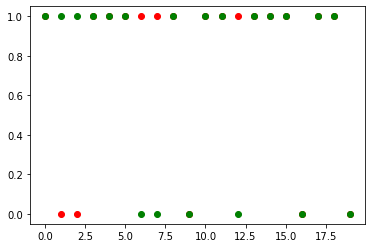

In [ ]:
plt.scatter(range(20),y_pred[:20],c="r")
plt.scatter(range(20),y_valid[:20],c="g")
plt.show()

## PREDICTING Y FOR TESTING DATA (1 FOR NEWS , 0 FOR CLICKBAIT)

In [ ]:
fh=test_heading_vector.reshape((test_heading_vector.shape[0],test_heading_vector.shape[1],1))
fb=test_body_vector.reshape((test_body_vector.shape[0],test_body_vector.shape[1],1))

In [ ]:
y_pred = model.predict([f1[:704],f2[:704]])

In [ ]:
for i in range(len(y_pred)):
  if(y_pred[i]<0.5):
    y_pred[i]=1
  else:
    y_pred[i]=0

In [ ]:
print("SHAPE OF Y PREDICTED : ")
print(y_pred.shape)
print()
print("Y PREDICTED VALUES FOR TESTING DATA (1 MEANS NEWS, 0 MEANS CLICKBAIT):")
print()
print(y_pred)


SHAPE OF Y PREDICTED : 
(704,)

Y PREDICTED VALUES FOR TESTING DATA (1 MEANS NEWS, 0 MEANS CLICKBAIT):

[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1